# Clustering

In this notebook, we learn about one of the most common un-supervised learning methods: clustering. There isn't a single algorithm for clustering, but the most common one is called **k-means clustering** where $k$ refers to the number of clusters we wish to have. Note that $k$ isn't really something we can learn from the data. It's something we must specify ahead of time, and while there are some guidelines we can use to choose a reasonable value for $k$ (see the assignment), ultimately it's somewhat of a subjective choice. In fact, with un-supervised learning in general, there is a lot of subjectivity involved, making it hard to interpret results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

census = pd.read_csv('../Data/adult_train.csv', sep = ",", header = 0)
census = census.drop(columns = ['fnlwgt', 'age'])
census.head()

,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


To make some of the results we generate a little easier to read, we will clean the data in the following way:
1. We relpace the any hyphen with underscore in the column names.
1. In the `income` column, we replace `<=` with `lt_` and `>` with `gt_`

In [2]:
census.columns = census.columns.str.replace("-", "_")

census["income"] = census["income"].replace("<=", "lt_", regex = True)#regex=True means that ... LOOK INTO
census["income"] = census["income"].replace(">", "gt_", regex = True)

census["income"].value_counts()

 lt_50K    24720
 gt_50K     7841
Name: income, dtype: int64

### Exercise (5 minutes)

Let's get a list of all the categorical columns in the data:

In [3]:
cat_vars = census.select_dtypes('object').columns.to_list()

- For each of the categorical columns in `cat_vars` do the following:
  - Find all the rows that have hypens and replace them with underscores.
  - Convert all the strings to lower case.

In [4]:
census[cat_vars] = census[cat_vars].replace({'-':'_'}, regex=True)

- Show the top 5 rows of the data to make sure your transformations worked.

In [6]:
census[cat_vars].head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,State_gov,Bachelors,Never_married,Adm_clerical,Not_in_family,White,Male,United_States,lt_50K
1,Self_emp_not_inc,Bachelors,Married_civ_spouse,Exec_managerial,Husband,White,Male,United_States,lt_50K
2,Private,HS_grad,Divorced,Handlers_cleaners,Not_in_family,White,Male,United_States,lt_50K
3,Private,11th,Married_civ_spouse,Handlers_cleaners,Husband,Black,Male,United_States,lt_50K
4,Private,Bachelors,Married_civ_spouse,Prof_specialty,Wife,Black,Female,Cuba,lt_50K


### End of exercise

The k-means clustering algorithm tries to find which rows of the data are similar to each other, where similarity is based having attributes (columns) that are close to each other. To determine closeness, we use **Euclidean distance**, although we can also experiment with other distance metrics. Let's say for the sake of example we have only two columns: `education_num` and `capital_gain`. Let's grab two rows of the data (can be any two rows):

In [7]:
which_cols = ['education_num', 'capital_gain']

two_rows = census.loc[[0, 197], which_cols]#Picking rows 0 and 197, capital gains has values in those columns; Have an idea for where the clustering should be based on those education levels
two_rows

,education_num,capital_gain
0,13,2174
197,14,14084


Let $E_0$ and $C_0$ refer to `education_num` and `capital_gain` at row with index 0, and $E_{197}$ and $C_{197}$ refer to `education_num` and `capital_gain` at row with index 197, the the Euclidean distance between the two rows is given by the following equation: 

$$D(0, 197) = \sqrt{(E_0-E_{197})^2 + (C_0-C_{197})^2}$$

To calculate this distance, it's probably easiest to convert our `DataFrame` to a `numpy` array first:

In [8]:
two_rows = two_rows.values # using values turns DataFrame into numpy array

In [9]:
two_rows

array([[   13,  2174],
       [   14, 14084]])

### Exercise (5 minutes)

- Use `numpy` to calculate the Euclidean distance between the two rows:

In [12]:
dist = np.linalg.norm(two_rows[0]-two_rows[1])

Notice that the Euclidian distance is dominated by the difference in the rows in the `captial_gain` column. This is because this column has a much bigger **scale** than `education_num`. So what can we do to make sure both columns can equally influence the distance? We can **normalize** the columns.

Use `numpy` to normalize the columns of the data. We will use **Z-normalization**, which is the following transformation: 

$$x_{\text{norm}} = \dfrac{x - \text{mean}(x)}{\text{std}(x)}$$

Where the mean and standard deviation are calculated on the **whole data**, not just the two rows above. 

- Find the mean and standard deviations of `education_num` and `capital_gain` for the whole `census` data and use them to normalize the `two_rows`. HINT: You can calculate the mean using this: `census[which_cols].values.mean(axis = 0)`. By default `axis = 0` but we specify it just to be sure. You can get the standard deviation similarly, using the `std` method.

In [13]:
census[[s + '_norm' for s in which_cols]] = (census[which_cols] - census[which_cols].values.mean(axis = 0))/census[which_cols].values.std(axis = 0)
census[[s + '_norm' for s in which_cols]] #Normalizing each of the rows and then calculating the distance, values are all between -2 and 2, have comparison across all data points

,education_num_norm,capital_gain_norm
0,1.134739,0.148453
1,1.134739,-0.145920
2,-0.420060,-0.145920
3,-1.197459,-0.145920
4,1.134739,-0.145920
...,...,...
32556,0.746039,-0.145920
32557,-0.420060,-0.145920
32558,-0.420060,-0.145920
32559,-0.420060,-0.145920


- Calculate the Euclidean distance of the normalized values of `two_rows`.

In [16]:
two_rows = census.loc[[0, 197],[s + '_norm' for s in which_cols]] #When you normalize they are all working off of the same scale, why there is a reason for scaling and normalizing the data
two_rows = two_rows.values

In [17]:
dist = np.linalg.norm(two_rows[0]-two_rows[1])
dist

1.6588715299689416

If we had more columns we simply add a squared difference for each to the formula, and the `numpy` code to compute the distance stays the same.

### End of exercise

Let's now normalize all our numeric columns in one go using `pandas`. First we get a list of the numeric columns:

In [36]:
num_cols = census.select_dtypes(['integer', 'float']).columns
print(num_cols)

Index(['education_num', 'capital_gain', 'capital_loss', 'hours_per_week',
       'education_num_norm', 'capital_gain_norm'],
      dtype='object')


Now we use the `apply` method to apply a function to all the numeric columns at once, using `axis = 0` to say that the function applies across rows. We can either create a function ahead of time and pass it to apply, or in our case since the function is quite simple, we simply create it on the fly using the **lambda notation**.

In [37]:
census_rescaled = census[num_cols]
census_rescaled = census_rescaled.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)
census_rescaled.head()

,education_num,capital_gain,capital_loss,hours_per_week,education_num_norm,capital_gain_norm
0,1.134721,0.148451,-0.216656,-0.035429,1.134721,0.148451
1,1.134721,-0.145918,-0.216656,-2.222119,1.134721,-0.145918
2,-0.420053,-0.145918,-0.216656,-0.035429,-0.420053,-0.145918
3,-1.197440,-0.145918,-0.216656,-0.035429,-1.197440,-0.145918
4,1.134721,-0.145918,-0.216656,-0.035429,1.134721,-0.145918


We can create a scatter plot of the `education_num` and `capital_gain`, which we used to illustrate our previous example.

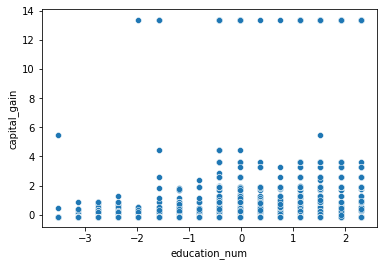

In [38]:
sns.scatterplot(x = 'education_num', y = 'capital_gain', data = census_rescaled); #Never do 3D plots

At first glance, it's seems hard to say if there are more than 2 clusters from looking at the scatter plot above. So should we pick $k=2$ or $k>2$? The answer is that there is no easy answer. $k=2$ might be a safe choice, but has little practical value (so you're telling me that the world is made up of very rich people and everyone else, thanks! I'm so glad I hired a data scientist...). With $k>2$ we can get more refined differences, but it's hard to know where to draw the line and what sets different groups apart. And here we only have two columns and the luxury of looking at scatter plots, but as the number of features goes this becomes a harder and harder problem. Well this is the curse of un-supervised learning!

So for now let's start with $k=2$ and use k-means to cluster the data. We use the `KMeans` function in `sklearn`. At this point, you should be familiar with the following pattern `KMeans` and other `sklearn` functions abide by:

1. We initialize the algorithm and specify any arguments if need be. In this case, the number of clusters.
1. We call `fit` and pass it the data. This is when learning happens.
1. We call `transform` and get predictions back. For k-means the predictions are the **cluster assignments**. Any row will be assigned one of $k$ labels, depending on which cluster they belong to. Note that assignments have no particular order to them: If you rerun the algorithm, what was cluster 2 last round might be called cluster 4 this round. The 2 and 4 are not important. What's important is that all the points in cluster 2 are similar to each other, and all the points in cluster 4 are similar to each other.

The above three steps are marked in the code below.

In [42]:
from sklearn.cluster import KMeans
n_clusters = 3 # the number of clusters (k)
which_cols = ['education_num', 'capital_gain']

X = census_rescaled[which_cols]#can add [which_cols] at end of rescaled
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
census_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
census_rescaled.head()

,education_num,capital_gain,capital_loss,hours_per_week,education_num_norm,capital_gain_norm,cluster
0,1.134721,0.148451,-0.216656,-0.035429,1.134721,0.148451,0
1,1.134721,-0.145918,-0.216656,-2.222119,1.134721,-0.145918,0
2,-0.420053,-0.145918,-0.216656,-0.035429,-0.420053,-0.145918,1
3,-1.197440,-0.145918,-0.216656,-0.035429,-1.197440,-0.145918,1
4,1.134721,-0.145918,-0.216656,-0.035429,1.134721,-0.145918,0


There is one thing to note about k-means. We said in the beginning that k-means is an un-supervised learning algorithm. This means that the data is not labeled ahead of time with clusters that we need to then learn. This means that there is no learning happening, and when we use k-means to assign each row to a cluster, we have no way to **evaluate** the label assignments and determine if we did a good job. This is why we call it **un-supervised**. However, we can still do something that we usually do with **supervised** learning algorithms: we can predict for any new row of data by assigning a cluster to it. How? We simply assign the new row by first normalizing it in the same way the training data was normalized and then assigning it whichever cluster **centroid** it is closest to (using Euclidean distance to measure closeness). 

Here's how we can find out what the cluster centroids are, but keep in mind that these are centroids based on the **normalized** data, so we have to **un-normalize** it by running the reverse transformation if we want them to be on the same scale as the original data.

In [43]:
kmeans.cluster_centers_

array([[ 1.13995526e+00,  4.64109553e-03],
       [-5.46579529e-01, -9.89756262e-02],
       [ 1.10294136e+00,  1.33943722e+01]])

We can measure the remaining variation in the data after we cluster the data by looking at the `inertia_` attribute. This value is computed as by taking the sum of squared distances of each data point to their closest cluster center.

In [44]:
kmeans.inertia_

16099.870549149375

Using `numpy` we can manually obtain this value. It helps sometimes to "reverse engineer" such computations to get a deeper understanding and familiarity with the algorithm. Examine the code below as one example.

In [45]:
inertia = 0

for cls in range(n_clusters):
    # find the subset of the data with cluster assignment
    census_subset_cls = census_rescaled.loc[census_rescaled['cluster'] == cls, which_cols].values
    # find the sum of the squared differences between the data and the corresponding centroid
    inertia += np.power(census_subset_cls - kmeans.cluster_centers_[cls], 2).sum()
    
print(inertia)

16099.870549149371


We can see that we're able to get the same value as what `KMeans` returned. Let's now check how the distribution of cluster assignments:

In [46]:
census_rescaled['cluster'].value_counts()

1    22005
0    10397
2      159
Name: cluster, dtype: int64

It is very important to note that while the cluster assignments are integers, they have no numeric value, meaning that the numbers are just labels. Cluster 1 is not necessarily closer to cluster 2 than it is to cluster 3. In fact, reruning `KMeans` doesn't guarantee that we will retain the same order. So to be safe, we will convert the `cluster` to `category` type.

In [47]:
census_rescaled['cluster'] = census_rescaled['cluster'].astype('category')

We can redraw our earlier scatter plot and color-code the points by the cluster they belong to.

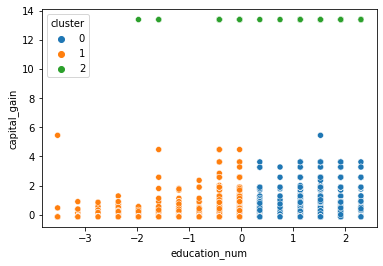

In [48]:
sns.scatterplot(x = 'education_num', y = 'capital_gain', hue = 'cluster', 
                data = census_rescaled);

### Exercise (10 minutes)

- Based on the above scatter plot, which of the two features do you think is more important in determining which cluster a person belongs to?
- Return to where we called `KMeans` and change the number of clusters now to $k=3$. Report your findings now: What differentiates cluster 1 form 2, 1 from 3, and 2 from 3?
- Try this again with $k=4$ and report your findings. You can see that as $k$ increases, we have more and more comparisons to make.
- Let's keep $k=4$, but this time pass all four numeric columns to `KMeans`. Do you notice any changes to the scatter plot above?

Of course since we added all four numeric columns to `KMeans`, then we have to look at scatter plots of all possible combinations of those four columns: there are $4 \choose 2$ (we read that as **4 choose 2**) which is $\frac{4!}{2!2!} = 6$ possible combinations. There is a very easy way to get all the combinations using the `itertools.combinations` function.

In [51]:
from itertools import combinations
all_pairs = list(combinations(num_cols, 2))

for pair in all_pairs:
    print(pair)

('education_num', 'capital_gain')
('education_num', 'capital_loss')
('education_num', 'hours_per_week')
('education_num', 'education_num_norm')
('education_num', 'capital_gain_norm')
('capital_gain', 'capital_loss')
('capital_gain', 'hours_per_week')
('capital_gain', 'education_num_norm')
('capital_gain', 'capital_gain_norm')
('capital_loss', 'hours_per_week')
('capital_loss', 'education_num_norm')
('capital_loss', 'capital_gain_norm')
('hours_per_week', 'education_num_norm')
('hours_per_week', 'capital_gain_norm')
('education_num_norm', 'capital_gain_norm')


Plot the all the possbile scatter plots from the pairs above.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

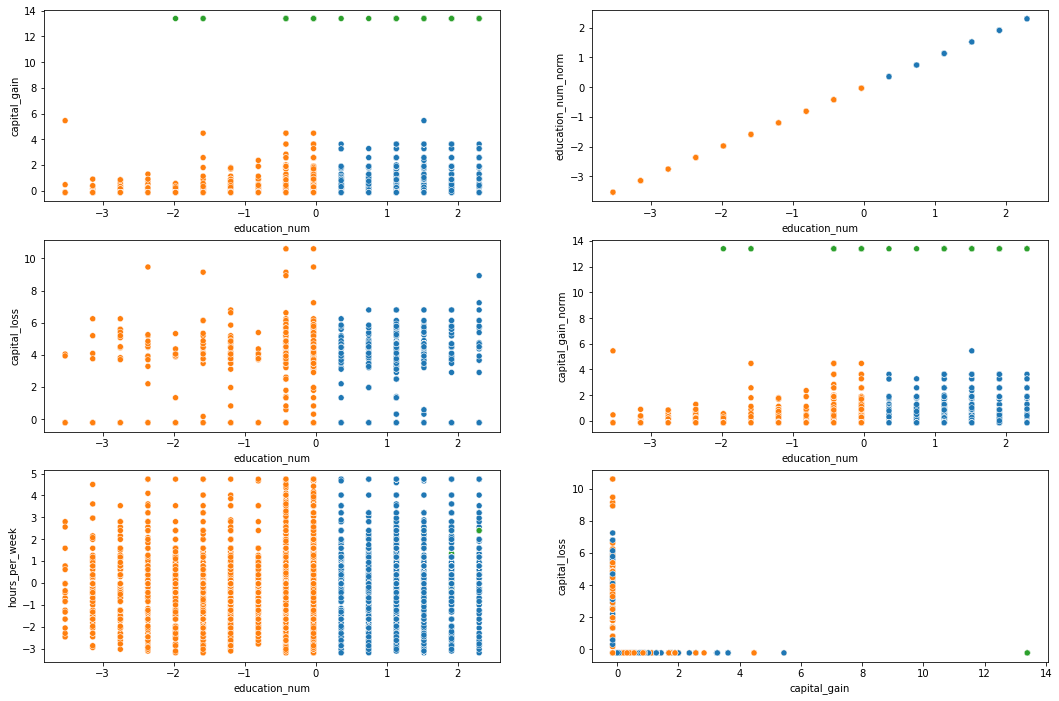

In [52]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (18, 12))
sns.scatterplot(*all_pairs[0], hue = 'cluster', data = census_rescaled, ax = axs[0, 0], legend = False);
sns.scatterplot(*all_pairs[1], hue = 'cluster', data = census_rescaled, ax = axs[1, 0], legend = False);
sns.scatterplot(*all_pairs[2], hue = 'cluster', data = census_rescaled, ax = axs[2, 0], legend = False);
sns.scatterplot(*all_pairs[3], hue = 'cluster', data = census_rescaled, ax = axs[0, 1], legend = False);
sns.scatterplot(*all_pairs[4], hue = 'cluster', data = census_rescaled, ax = axs[1, 1], legend = False);
sns.scatterplot(*all_pairs[5], hue = 'cluster', data = census_rescaled, ax = axs[2, 1], legend = False);

Let's say you are now charged with **profiling** the clusters. That means you need to come up with a brief description of each of the 4 clusters. You can rely on the above scatter plots or any other summaries you like. This is not necessarily an easy task, and the point is to show you the challenge of dealing with un-supervised learning algorithms. Imagine how much harder this would have been with a much larger $k$ or with more features in the data!

In the next notebook, we will use decision trees to help us with this task. Don't worry, there's better ways of doing this than having to look at tons of scatter plots...

### End of exercise

Our clusters so far only used the numeric columns in the data, but we also have a lot of categorical columns and we should be using them too. As we saw earlier k-means clustering relies on Euclidean distance to measure the similarity between the rows. So how do you measure Euclidean distance when you have categorical data? The answer is  one-hot encoding. The quick and easy way to do this is using `pd.get_dummies` function. One-hot encoded (binary) features are also called **dummy variables**, which explains why the function is named `get_dummies`.

In [53]:
cat_vars = census.select_dtypes('object').columns.to_list()
census_onehot = pd.get_dummies(census[cat_vars])
census_onehot.head()

,workclass_ ?,workclass_ Federal_gov,workclass_ Local_gov,workclass_ Never_worked,workclass_ Private,workclass_ Self_emp_inc,workclass_ Self_emp_not_inc,workclass_ State_gov,workclass_ Without_pay,education_ 10th,...,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United_States,native_country_ Vietnam,native_country_ Yugoslavia,income_ gt_50K,income_ lt_50K
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Let's combine our standardized numeric features and our one-hot-encoded categorical features into one data and train `KMeans` on it.

In [54]:
census_featurized = pd.concat([census_rescaled, census_onehot], axis = 1)

We're going to train with $k=5$ just to use a bigger number.

In [55]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
kmeans.fit(census_featurized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

Instead of adding the clusters as a new column to the featurized data, we add them to the original data. This way we can get summaries on the original (non-normalized) numeric features which makes it easier to interpret results.

In [56]:
census['cluster'] = kmeans.predict(census_featurized)

In [57]:
census.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,education_num_norm,capital_gain_norm,cluster
0,State_gov,Bachelors,13,Never_married,Adm_clerical,Not_in_family,White,Male,2174,0,40,United_States,lt_50K,1.134739,0.148453,1
1,Self_emp_not_inc,Bachelors,13,Married_civ_spouse,Exec_managerial,Husband,White,Male,0,0,13,United_States,lt_50K,1.134739,-0.145920,1
2,Private,HS_grad,9,Divorced,Handlers_cleaners,Not_in_family,White,Male,0,0,40,United_States,lt_50K,-0.420060,-0.145920,0
3,Private,11th,7,Married_civ_spouse,Handlers_cleaners,Husband,Black,Male,0,0,40,United_States,lt_50K,-1.197459,-0.145920,0
4,Private,Bachelors,13,Married_civ_spouse,Prof_specialty,Wife,Black,Female,0,0,40,Cuba,lt_50K,1.134739,-0.145920,1


For example, here's the average of the numeric features grouped by each cluster. It's definitely easier to compare clusters this way than having to look at all those scatter plots.

In [58]:
census.groupby('cluster').mean()

,education_num,capital_gain,capital_loss,hours_per_week,education_num_norm,capital_gain_norm
cluster,,,,,,
0,8.679637,345.274376,66.798912,39.174014,-0.544585,-0.099168
1,13.021349,1118.255699,132.320711,42.984834,1.143037,0.005498
2,12.918239,99999.000000,0.000000,49.798742,1.102958,13.394578


In addition to comparing averages, it's also important to compare the variability within each cluster. However, if we want to compare variability across features, we need to use standardized features otherwise features on a larger scale will always have more variability.

In [59]:
census_rescaled.groupby('cluster').std()

,education_num,capital_gain,capital_loss,hours_per_week,education_num_norm,capital_gain_norm
cluster,,,,,,
0,0.451420,0.493615,1.219760,0.972852,0.451420,0.493615
1,0.674701,0.241667,0.876585,0.997318,0.674701,0.241667
2,0.963054,0.000000,0.000000,1.008372,0.963054,0.000000


How do we check how clusters compare across the categories of our categorical variables? One way is to look at two-way tables. We can use `pd.crosstab` for that.

In [60]:
pd.crosstab(census['cluster'], census['workclass'])

workclass,?,Federal_gov,Local_gov,Never_worked,Private,Self_emp_inc,Self_emp_not_inc,State_gov,Without_pay
cluster,,,,,,,,,
0,1483,543,1043,7,16089,569,1651,652,13
1,349,416,1044,0,6525,511,861,645,1
2,4,1,6,0,82,36,29,1,0


### Exercise (4 minutes)

- How can we make the above information more useful. We can turn the counts into percentages by cluster. Find how you can use the `normalize` argument, to turn the counts into percentages. Note that `normalize` here has nothing to do with Z-normalization we learned earlier.

In [61]:
pd.crosstab(census['cluster'], census['workclass'], normalize=True)

workclass,?,Federal_gov,Local_gov,Never_worked,Private,Self_emp_inc,Self_emp_not_inc,State_gov,Without_pay
cluster,,,,,,,,,
0,0.045545,0.016676,0.032032,0.000215,0.494119,0.017475,0.050705,0.020024,0.000399
1,0.010718,0.012776,0.032063,0.000000,0.200393,0.015694,0.026443,0.019809,0.000031
2,0.000123,0.000031,0.000184,0.000000,0.002518,0.001106,0.000891,0.000031,0.000000


- Even more useful would be to display the above table with the percentages as a **heat map**, so that we can quickly compare the distribution of the clusters across different occupations. Turn the above table into a heat map using `seaborn`.

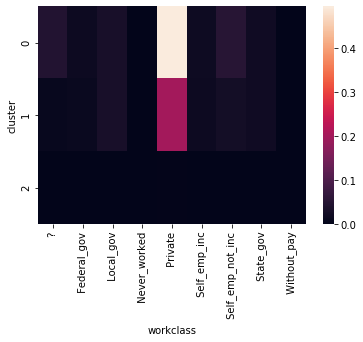

In [62]:
sns.heatmap(pd.crosstab(census['cluster'], census['workclass'], normalize=True))

- Does anything particularly stand out? Can you refine your profile of each of the clusters based on what you see? It might help to also try other categorical features like `education`, `marital_status`, or `income`.

### End of exercise

There's so much more to say about clustering. Here are two examples:

- We could try to solve the problem of clustering when we have categorical data by defining a distance function that works for categorical data. 
- We could try to find a way to cluster the data **hierarchically**, so that we depend less on a specific choice of $k$. Instead we narrow our choice later by choosing the level of hierarchy we want to stop at. 

The topic of clustering can be its own course, and admittedly the `KMeans` algorithm in `sklearn` is rather limited. So we should also explore other options.

# Assignment

In the previous assignment, we featurized the `retail-churn.csv` data using RFM. In this assignment, we build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end. 

In [1]:
import pandas as pd

col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../Data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


1. Rerun the feature engineering steps on the data to extract RFM features. <span style="color:red" float:right>[2 point]</span>

Reasoning - Will rerun the same engineering steps as from assignment 7 to get the necessary data organized

In [2]:
churn['timestamp'] = pd.to_datetime(churn['timestamp'])

churn['date']=churn['timestamp'].dt.strftime("%Y-%m-%d")
churn['date'] = pd.to_datetime(churn['date'])
churn['date'].head()

churn_agg = churn.groupby(['user_id', 'date'], as_index=False).agg({'quantity':'sum', 'dollar':'sum'})
churn_agg['last_visit_ndays']=churn_agg.groupby('user_id')['date'].diff()

churn_agg.set_index('date', inplace=True)


quantity_roll_sum_7D = churn_agg.groupby('user_id').rolling('7D')['quantity'].sum()
dollar_roll_sum_7D = churn_agg.groupby('user_id').rolling('7D')['dollar'].sum()

churn_agg.reset_index(inplace=True)

churn_agg.set_index(['user_id', 'date'], inplace=True)

last_visit_n_days_roll = churn_agg['last_visit_ndays']

churn_roll = pd.concat([quantity_roll_sum_7D, dollar_roll_sum_7D, last_visit_n_days_roll], axis=1)

churn_roll.rename(columns = {'quantity':'quantity_roll_sum_7D', 'dollar':'dollar_roll_sum_7D', 'recency':'last_visit_n_days_roll'}, inplace=True)
churn_roll['last_visit_ndays'].fillna(pd.Timedelta('100 days'), inplace=True)
print(churn_roll.head())

                    quantity_roll_sum_7D  dollar_roll_sum_7D last_visit_ndays
user_id date                                                                 
1113    2000-11-12                   5.0               420.0         100 days
        2000-11-26                   3.0               558.0          14 days
        2000-11-27                   9.0              1182.0           1 days
1823    2000-11-02                  16.0              1256.0         100 days
        2000-11-06                  22.0              2174.0           4 days


Conclusion - was able to get the quantity, dollar, and last visit set up - only assumption is that I left the 100 days for the N/A, assumed that was necessary to be able to standardize the data and then run the model off of

2. Train a k-means algorithm on the RFM features using $k = 10$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the standardized scale. <span style="color:red" float:right>[2 point]</span> 

Reasoning - Drawing from the lecture above for the k-means algorithm, I am going to import numpy and calculate the number of days as an integer so I can work with it

In [3]:
import numpy as np

#churn_roll['days_RFM']=churn_roll['last_visit_ndays'].astype(int)###/60)/60)/24)
#churn_roll['days_RFM']=churn_roll['last_visit_ndays'].astype(np.)

###churn_roll['last_visit_ndays'].apply(lambda x:x.toordinal())
churn_roll['days_RFM'] = churn_roll['last_visit_ndays'].dt.days

churn_roll.dtypes

quantity_roll_sum_7D            float64
dollar_roll_sum_7D              float64
last_visit_ndays        timedelta64[ns]
days_RFM                          int64
dtype: object

In [4]:
churn_roll.head()

quantity_roll_sum_7D  dollar_roll_sum_7D last_visit_ndays  \
user_id date                                                                    
1113    2000-11-12                   5.0               420.0         100 days   
        2000-11-26                   3.0               558.0          14 days   
        2000-11-27                   9.0              1182.0           1 days   
1823    2000-11-02                  16.0              1256.0         100 days   
        2000-11-06                  22.0              2174.0           4 days   

                    days_RFM  
user_id date                  
1113    2000-11-12       100  
        2000-11-26        14  
        2000-11-27         1  
1823    2000-11-02       100  
        2000-11-06         4

In [5]:
num_cols= ['quantity_roll_sum_7D','dollar_roll_sum_7D','days_RFM']
churn_rescaled = churn_roll[num_cols]
churn_rescaled = churn_rescaled.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)
churn_rescaled.head()


quantity_roll_sum_7D  dollar_roll_sum_7D  days_RFM
user_id date                                                          
1113    2000-11-12             -0.288368           -0.408054  1.067950
        2000-11-26             -0.352871           -0.340820 -0.793828
        2000-11-27             -0.159362           -0.036804 -1.075259
1823    2000-11-02              0.066397           -0.000751  1.067950
        2000-11-06              0.259906            0.446502 -1.010313

In [6]:
from sklearn.cluster import KMeans
n_clusters = 10 # the number of clusters (k)
which_cols = ['quantity_roll_sum_7D', 'dollar_roll_sum_7D', 'days_RFM']

X = churn_rescaled[which_cols]#can add [which_cols] at end of rescaled
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
churn_rescaled.head()



quantity_roll_sum_7D  dollar_roll_sum_7D  days_RFM  \
user_id date                                                             
1113    2000-11-12             -0.288368           -0.408054  1.067950   
        2000-11-26             -0.352871           -0.340820 -0.793828   
        2000-11-27             -0.159362           -0.036804 -1.075259   
1823    2000-11-02              0.066397           -0.000751  1.067950   
        2000-11-06              0.259906            0.446502 -1.010313   

                    cluster  
user_id date                 
1113    2000-11-12        1  
        2000-11-26        0  
        2000-11-27        0  
1823    2000-11-02        7  
        2000-11-06        9

In [7]:
###Potential question, ask about this -- potentially on standardized values

###Get cluster centers from normalized or original data???

kmeans.cluster_centers_

###call from sklearn to get clusters from inverse

###Potentially take one of the centers and multiply by std and add to mean

###can use .reverse_transform - in order to use I have to also sklearn standardize

array([[-0.17718502, -0.31858666, -0.90153358],
       [-0.24842768, -0.39082408,  1.0679497 ],
       [ 6.17481066, 17.01722537, -1.0593834 ],
       [ 0.63376734,  1.43277016,  1.0679497 ],
       [53.05543032, 20.25817244, -1.07525902],
       [28.46553763,  7.78921037, -1.01271869],
       [ 1.02754616,  2.24966794, -0.99077834],
       [ 0.1480627 ,  0.23332454,  1.0679497 ],
       [ 1.9331838 ,  6.61838552, -0.79467653],
       [ 0.34119602,  0.49268149, -0.96767328]])

In [8]:
####Make sure to return in non-rescaled columns - read through on this

Conclusion - Was a little confused over the aspect of shifting them back to the original data, ran the kmeans.cluster_centers but not sure if that was the correct thing to do

3. Our earlier choice of $k=5$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 3 to 15. <span style="color:red" float:right>[3 point]</span>

Reasoning - Will need to create a range, and pass it through a for loop to get all of the necessary (3-15) point 

In [9]:
import seaborn as sns
distortions = []
K = range(3,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(churn_rescaled)
    distortions.append(kmeanModel.inertia_)

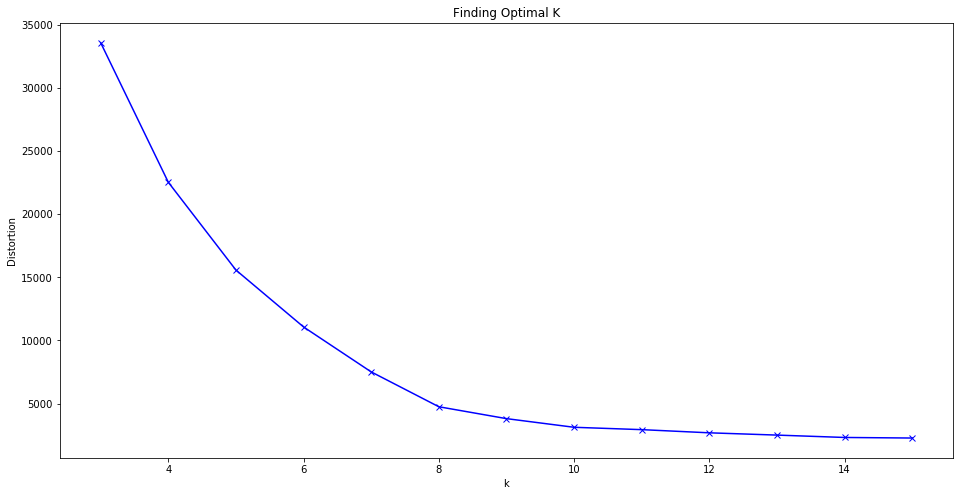

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Finding Optimal K')
plt.show()

###Can also build a confusion matrix and tweak the values - make a little plot instead of eyeballing

###Look into finding a way to get the most efficient k means cluster
Conclusion - Was able to get my scree plot all set up and ready to analyze based on the 'elbow' point

Conclusion - Was able to find that, based on the scree plot, 8 would be the best option

4. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span>

8 - where the slope tails off the most, showing the point where the slope decreases the most from one point to the next point, showing the ideal number of clusters to run with

5. Train a k-means algorithm on the RFM features using your new value of $k$. Report the  size, mean and standard deviation for the RFM features for each cluster. <span style="color:red" float:right>[2 point]</span>

Reasoning - Will rerun the code from above but changing the number of clusters to 8 instead of 3-15 and take a look at the size, mean, and std

In [11]:

n_clusters = 8 # the number of clusters (k)
which_cols = ['quantity_roll_sum_7D', 'dollar_roll_sum_7D', 'days_RFM']

X = churn_rescaled[which_cols]#can add [which_cols] at end of rescaled
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_rescaled['cluster_8'] = kmeans.predict(X) # step 3, assign a cluster to each row
churn_rescaled.head()
#1 way describe
#churn_rescaled.groupby('cluster_8').describe()### can also do mean() std() size()
#2 way is to use calls
print(churn_rescaled.groupby('cluster_8').mean())
print(churn_rescaled.groupby('cluster_8').std())
print(churn_rescaled.groupby('cluster_8').size())


           quantity_roll_sum_7D  dollar_roll_sum_7D  days_RFM   cluster
cluster_8                                                              
0                     -0.208419           -0.330942  1.067950  1.862530
1                      0.458604            0.753321 -0.977095  8.626490
2                     28.465538            7.789210 -1.012719  5.000000
3                      4.767421           15.502619 -0.958769  3.714286
4                      1.346518            3.563119 -0.692543  6.026786
5                      0.352652            0.660806  1.067950  5.841152
6                     -0.148453           -0.281064 -0.905432  0.769387
7                     53.055430           20.258172 -1.075259  4.000000
           quantity_roll_sum_7D  dollar_roll_sum_7D  days_RFM   cluster
cluster_8                                                              
0                      0.164530            0.208641  0.000000  2.105261
1                      0.412567            0.493776  0.136742  0

Conclusion - Can see that the sizes fluctuate quite a bit, with cluster 6 having the most, can also run this by using the .describe() call as well

6. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span>

Reasoning - I will select 1, 5, and 7 to examine and see what their associated features are

In [12]:
kmeans=KMeans(n_clusters=8)
label = kmeans.fit_predict(churn_rescaled)
print(label)



[2 1 1 ... 2 6 2]


In [13]:
import matplotlib.pyplot as plt

churn_0=churn_rescaled[label==0]
churn_4=churn_rescaled[label==4]
churn_6=churn_rescaled[label==6]

In [14]:
#plt.scatter(churn_0[:,0] , churn_0[:,1] , color = 'red')
#plt.scatter(churn_4[:,0] , churn_4[:,1] , color = 'blue')
#plt.scatter(churn_6[:,0] , churn_6[:,1] , color = 'yellow')

#plt.show()

In [15]:
clus_0=churn_rescaled[churn_rescaled.cluster_8==0]
clus_4=churn_rescaled[churn_rescaled.cluster_8==4]
clus_6=churn_rescaled[churn_rescaled.cluster_8==6]

In [16]:
clus_0.describe()

,quantity_roll_sum_7D,dollar_roll_sum_7D,days_RFM,cluster,cluster_8
count,4932.000000,4932.000000,4932.00000,4932.000000,4932.0
mean,-0.208419,-0.330942,1.06795,1.862530,0.0
std,0.164530,0.208641,0.00000,2.105261,0.0
min,-0.417373,-0.608295,1.06795,1.000000,0.0
25%,-0.352871,-0.501597,1.06795,1.000000,0.0
50%,-0.256116,-0.375898,1.06795,1.000000,0.0
75%,-0.127111,-0.188690,1.06795,1.000000,0.0
max,0.550168,0.397782,1.06795,7.000000,0.0


In [17]:
clus_4.describe()

,quantity_roll_sum_7D,dollar_roll_sum_7D,days_RFM,cluster,cluster_8
count,224.000000,224.000000,224.000000,224.000000,224.0
mean,1.346518,3.563119,-0.692543,6.026786,4.0
std,1.116210,1.427829,0.755973,1.391581,0.0
min,-0.352871,1.585098,-1.075259,3.000000,4.0
25%,0.582420,2.622965,-1.075259,6.000000,4.0
50%,1.195196,3.144152,-1.031962,6.000000,4.0
75%,1.912790,3.971790,-0.945368,6.000000,4.0
max,6.516675,8.835671,1.067950,8.000000,4.0


In [18]:
clus_6.describe()

,quantity_roll_sum_7D,dollar_roll_sum_7D,days_RFM,cluster,cluster_8
count,5416.000000,5416.000000,5416.000000,5416.000000,5416.0
mean,-0.148453,-0.281064,-0.905432,0.769387,6.0
std,0.192666,0.220453,0.159268,2.516684,0.0
min,-0.417373,-0.608295,-1.075259,0.000000,6.0
25%,-0.288368,-0.459697,-1.031962,0.000000,6.0
50%,-0.191614,-0.324742,-0.945368,0.000000,6.0
75%,-0.030357,-0.133149,-0.815476,0.000000,6.0
max,0.646923,0.465990,-0.274262,9.000000,6.0


Conclusion - Can see that the count for 1 and 7 is much higher than for 5, the associated features in the RFM all change as well due to the specific clusters. The standard deviation is the highest in cluster 5 while the other two clusters have relatively low std. The max values for 0 and 7 are also similar while much higher for 5. Seems to be much higher variation in cluster 5, interesting dynamic. 

# End of assignment